In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

# DarkHistory with Different Channels

In [12]:
%autoreload


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib
matplotlib.rc_file('matplotlibrc')
matplotlib.rcParams['figure.figsize'] = [8,8]


# SET THIS TO TRUE TO USE LATEX
matplotlib.rcParams['text.usetex'] = True

from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

from astropy.io import fits

from scipy.interpolate import PchipInterpolator
from scipy.interpolate import pchip_interpolate
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import griddata


# np.set_printoptions(threshold=np.nan)

In [3]:
# Each row is given by mDM, log10x and the spectrum (dN/d log_10 x) into the following channels:

# mDM, log[10,x], eL, eR, e, mu_L, mu_R, mu, tau_L, tau_R, tau, q, c, b, t, 
# WL, WT, W, ZL, ZT, Z, g, gamma, h, nu_e, nu_mu, nu_tau, V--> e, V--> mu, V--> tau

# gamma_spec_raw = np.genfromtxt('/Users/hongwan/Dropbox (MIT)/Photon Deposition/PPPC4DMID Data/AtProduction_gammas.dat', dtype=float, skip_header=True)
# positron_spec_raw = np.genfromtxt('/Users/hongwan/Dropbox (MIT)/Photon Deposition/PPPC4DMID Data/AtProduction_positrons.dat', dtype=float, skip_header=True)

import json

coords_file_name = '/Users/hongwan/Desktop/dlNdlxIEW_coords_table.txt'
values_file_name = '/Users/hongwan/Desktop/dlNdlxIEW_values_table.txt'

with open(coords_file_name) as data_file:    
    coords_data = np.array(json.load(data_file))
with open(values_file_name) as data_file:
    values_data = np.array(json.load(data_file))

    

In [20]:
values_data.shape

(2, 23)

In [4]:
chan_list = [
    'e_L',
    'e_R', 'mu_L', 'mu_R', 'tau_L', 'tau_R',
    'q',  'c',  'b', 't',
    'W_L', 'W_T', 'Z_L', 'Z_T',
    'g',  'gamma', 'h',
    'nu_e', 'nu_mu', 'nu_tau',
    'VV_to_4e', 'VV_to_4mu', 'VV_to_4tau'
]

idx_list = {
    'e_L': 0, 'e_R': 1, 'mu_L': 2, 'mu_R': 3, 'tau_L': 4, 'tau_R': 5,
    'q': 6, 'c': 7, 'b': 8, 't': 9,
    'W_L': 10, 'W_T': 11, 'Z_L': 12, 'Z_T': 13,
    'g': 14, 'gamma': 15, 'h': 16,
    'nu_e': 17, 'nu_mu': 18, 'nu_tau': 19,
    'VV_to_4e': 20, 'VV_to_4mu': 21, 'VV_to_4tau': 22
}

class PchipInterpolator2D: 
    
    def __init__(self, chan_prompt, chan_final_state):
        if chan_final_state == 'elec':
            i = 0
            fac = 2.
        elif chan_final_state == 'phot':
            i = 1
            fac = 1.
        else:
            raise TypeError('invalid final state.')
            
        self.chan_prompt = chan_prompt
            
        if chan_prompt == 'e' or chan_prompt == 'mu' or chan_prompt == 'tau':
            chan_prompt_1 = chan_prompt + '_L'
            chan_prompt_2 = chan_prompt + '_R'
            self.weight = [0.5, 0.5]
        elif chan_prompt == 'W' or chan_prompt == 'Z':
            chan_prompt_1 = chan_prompt + '_T'
            chan_prompt_2 = chan_prompt + '_L'
            self.weight = [2/3, 1/3]
        else:
            chan_prompt_1 = chan_prompt
            chan_prompt_2 = chan_prompt
            self.weight = [0.5, 0.5]
            
        mDM_in_GeV_arr_1 = np.array(coords_data[i, idx_list[chan_prompt_1], 0])
        log10x_arr_1     = np.array(coords_data[i, idx_list[chan_prompt_1], 1])
        values_arr_1     = np.array(values_data[i, idx_list[chan_prompt_1]])
        mDM_in_GeV_arr_2 = np.array(coords_data[i, idx_list[chan_prompt_2], 0])
        log10x_arr_2     = np.array(coords_data[i, idx_list[chan_prompt_2], 1])
        values_arr_2     = np.array(values_data[i, idx_list[chan_prompt_2]])

        self.mDM_in_GeV_arrs = [mDM_in_GeV_arr_1, mDM_in_GeV_arr_2] 
        self.log10x_arrs     = [log10x_arr_1,     log10x_arr_2]

        self.interpolators = [
            PchipInterpolator(mDM_in_GeV_arr_1, values_arr_1 + np.log10(fac), extrapolate=False),
            PchipInterpolator(mDM_in_GeV_arr_2, values_arr_2 + np.log10(fac), extrapolate=False)
        ]
    
    def get_val(self, mDM_in_GeV, log10x):
        
        if (
            mDM_in_GeV < self.mDM_in_GeV_arrs[0][0] 
            or mDM_in_GeV < self.mDM_in_GeV_arrs[1][0]
            or mDM_in_GeV > self.mDM_in_GeV_arrs[0][-1]
            or mDM_in_GeV > self.mDM_in_GeV_arrs[1][-1]
        ):
            raise TypeError('mDM lies outside of the interpolation range.')
        
        result1 = pchip_interpolate(
            self.log10x_arrs[0], self.interpolators[0](mDM_in_GeV), log10x
        )
        result1[log10x >= self.log10x_arrs[0][-1]] = -100.
        result1[log10x <= self.log10x_arrs[0][0]]  = -100.
        
        result2 = pchip_interpolate(
            self.log10x_arrs[1], self.interpolators[1](mDM_in_GeV), log10x
        )
        result2[log10x >= self.log10x_arrs[1][-1]] = -100.
        result2[log10x <= self.log10x_arrs[1][0]]  = -100.
        
        return np.log10(self.weight[0]*10**result1 + self.weight[1]*10**result2)


In [5]:
chan_list = [
    'e_L','e_R', 'e', 
    'mu_L', 'mu_R', 'mu',
    'tau_L', 'tau_R', 'tau',
    'q',  'c',  'b', 't',
    'W_L', 'W_T', 'W',
    'Z_L', 'Z_T', 'Z',
    'g',  'gamma', 'h',
    'nu_e', 'nu_mu', 'nu_tau',
    'VV_to_4e', 'VV_to_4mu', 'VV_to_4tau'
]

dlNdlxIEW_interp = {'elec':{}, 'phot':{}}

for prompt_chan in chan_list:
    dlNdlxIEW_interp['elec'][prompt_chan] = PchipInterpolator2D(prompt_chan, 'elec')
    dlNdlxIEW_interp['phot'][prompt_chan] = PchipInterpolator2D(prompt_chan, 'phot')


In [6]:
def get_normalized_spec(mDM, eng, chan_prompt, chan_final_state):
    
    mass_threshold = {
        'e_L'   : phys.mass['e'],   'e_R'   : phys.mass['e'],     'e': phys.mass['e'],
        'mu_L'  : phys.mass['mu'],  'mu_R'  : phys.mass['mu'],   'mu': phys.mass['mu'],
        'tau_L' : phys.mass['tau'], 'tau_R' : phys.mass['tau'], 'tau': phys.mass['tau'],
        'q'     : 0.,
        'c'     : phys.mass['c'],   'b'     : phys.mass['b'],     't': phys.mass['t'],
        'W_L'   : phys.mass['W'],   'W_T'   : phys.mass['W'],     'W': phys.mass['W'],
        'Z_L'   : phys.mass['Z'],   'Z_R'   : phys.mass['Z'],     'Z': phys.mass['Z'],
        'g'     : 0.,               'gamma' : 0.,                 'h': phys.mass['h'],
        'nu_e'  : 0.,               'nu_mu' : 0.,            'nu_tau': 0.,
        'VV_to_4e' : 2*phys.mass['e'], 'VV_to_4mu' : 2*phys.mass['mu'], 'VV_to_4tau' : 2*phys.mass['tau']
    }
    
    log10x = np.log10(eng/mDM)

    # For electron final states, there is a mandatory binning into very fine bins, 
    # in order to capture the peaky distribution.
    if chan_final_state == 'elec' and (
        chan_prompt == 'e_L' or chan_prompt == 'e_R' 
        or chan_prompt == 'e' or chan_prompt == 'VV_to_4e'
    ):
        while log10x.size < 500000:
            log10x = np.interp(np.arange(0, log10x.size-0.5, 0.5), np.arange(log10x.size), log10x)
    
    # Get the reference spectrum, interpolating over mDM only. 
    # Abscissa is log10x_arr. These spectra take mDM in GeV.
    if mDM < mass_threshold[chan_prompt]:
        # This avoids the absurd situation where mDM is less than the threshold
        # but we get a nonzero spectrum due to interpolation.
        return Spectrum(eng, np.zeros_like(eng), spec_type='dNdE')
    
    dN_dlog10x = 10**dlNdlxIEW_interp[chan_final_state][chan_prompt].get_val(mDM/1e9, log10x)
    
#     dN/dE = dN/dlog10x * dlog10x/dE
    x = 10**log10x
    spec = Spectrum(x*mDM, dN_dlog10x/(x*mDM*np.log(10)), spec_type='dNdE')
    
    # rebin down to the original binning. 
    if chan_final_state == 'elec' and (
        chan_prompt == 'e_L' or chan_prompt == 'e_R' 
        or chan_prompt == 'e' or chan_prompt == 'VV_to_4e'
    ):
        spec.rebin(eng)
        
    return spec


0.27167398755391076
0.17777965389108244
0.4494536414449932


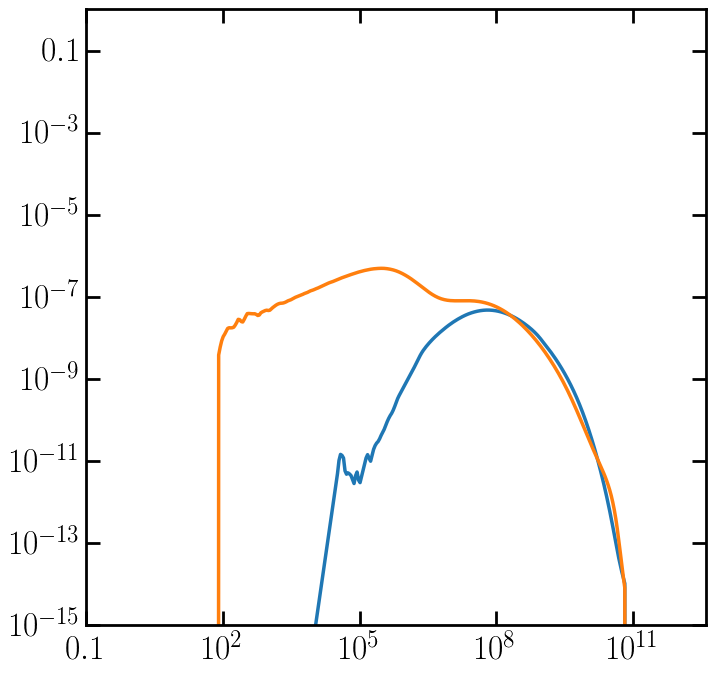

In [18]:
%autoreload
eng = 10**np.arange(-4, 12.5, 16.5/500)

mDM = 7e10
chan = 'b'

test_phot = get_normalized_spec(mDM, eng, chan, 'phot')
test_elec = get_normalized_spec(mDM, eng, chan, 'elec')


# print(test_phot)

plt.figure()

plt.loglog()

plt.plot(eng, test_phot.dNdE)
plt.plot(eng, test_elec.dNdE)

plt.axis([1e-1, 4e12, 1e-15, 1])
# plt.axis([1e-10, 10, 1e-10, 3000])

print(test_phot.toteng()/(2*mDM )) 
print(test_elec.toteng()/(2*mDM))
print(test_phot.toteng()/(2*mDM) + test_elec.toteng()/(2*mDM))
